In [1]:
import tensorflow as tf
import re
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from keras_tuner.tuners import RandomSearch
import numpy as np
import pickle
import math

# Prepare Corpus

In [2]:
df = pd.read_excel("Book1.xlsx")
df.head()

,text,label,username,social,time
0,Masih bisa di berikan kewarasan mental dan di ...,0,@aliifah1024,Threads,"Thursday, December 19, 2024 at 8:51 AM"
1,Bersyukur memang tidak semuany bisa kita milik...,0,@inspirasi.keluarga,Threads,"Thursday, December 19, 2024 at 8:50 AM"
2,Cantik manis cewe nya .. cocok ajalah,0,@azmiel_09,Threads,"Thursday, December 19, 2024 at 9:31 AM"
3,"Emang bener, Tuhan tu sengaja mempertemukan ki...",0,@rionaldokristayuda,Threads,"Thursday, December 19, 2024 at 4:59 AM"
4,Semoga Allah jadikan kita hamba yang dapat dan...,0,@benerbareng,Threads,"Thursday, December 19, 2024 at 9:39 AM"


# Preprocessing

In [3]:
def case_folding(text):
    return text.lower()

#NOISE REMOVAL
def noise_removal(text):
    #menghapus http / https
    text = re.sub(r'https?://\S+', '', text)
    #menghapus hashtag
    text = re.sub(r'#\S+', '', text)
    #menghapus angka
    text = re.sub(r'(?<!\w)\b\d+\b(?!\w)', '', text)
    #menghapus special character
    text = re.sub(r'[^\w\s]', '', text)
    #menghapus spasi yang berlebihan
    text = re.sub(r'\s+', ' ', text).strip()
    return text

#SLANG WORD
slang_word_df = pd.read_csv("kamus_slangword.csv")
slang_dict = slang_word_df.set_index('slang')['formal'].to_dict()
def convert_to_formal(sentence):
    words = sentence.split()  # Split the sentence into words
    replaced_sentence = [slang_dict.get(word, word) for word in words]  # Replace slang with formal words
    return ' '.join(replaced_sentence)

#Stemming
stemmer = StemmerFactory().create_stemmer()

#Stopword Removal
stopper = StopWordRemoverFactory().create_stop_word_remover()

In [4]:
df['text'] = df['text'].apply(lambda text: stopper.remove(
        stemmer.stem(
            convert_to_formal(
                noise_removal(
                    case_folding(text)
                )
            )
        )
    ))

In [5]:
preprocessed_df = df[['text', 'label', 'username', 'social', 'time']]
preprocessed_df = preprocessed_df.drop_duplicates(subset=['text'], keep='last')

In [6]:
# Calculate the distribution of labels
label_distribution = preprocessed_df['label'].value_counts()
# Sort the distribution by label if needed
label_distribution = label_distribution.sort_index()
# Display the distribution
print(label_distribution)

label
0    100
1    100
2    100
3    100
Name: count, dtype: int64


In [7]:
oov_tok = "<OOV>"
trunc_type = 'post'

# Data Splitting

In [8]:
shuffled_df = preprocessed_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_size = int(0.80 * len(shuffled_df))

train_df = shuffled_df.iloc[:train_size]
test_df = shuffled_df.iloc[train_size:]

train_text, train_label = train_df['text'].tolist(), train_df['label'].tolist()
test_text, test_label = test_df['text'].tolist(), test_df['label'].tolist()

# Tokenizing

In [9]:
# Initialize and fit tokenizer
tokenizer = Tokenizer(num_words=1500, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)

In [10]:
print(tokenizer.word_index)
print(len(tokenizer.word_index))

{'<OOV>': 1, 'aku': 2, 'kamu': 3, 'lu': 4, 'sama': 5, 'sangat': 6, 'bangga': 7, 'orang': 8, 'anjing': 9, 'bodoh': 10, 'kalau': 11, 'jadi': 12, 'sih': 13, 'kontol': 14, 'nya': 15, 'bangsat': 16, 'pimpin': 17, 'pengin': 18, 'buat': 19, 'kompeten': 20, 'tidak': 21, 'otak': 22, 'semua': 23, 'emut': 24, 'fufufafa': 25, 'apa': 26, 'anak': 27, 'mau': 28, 'dungu': 29, 'kasih': 30, 'nikmat': 31, 'babi': 32, 'selalu': 33, 'hebat': 34, 'terima': 35, 'tolol': 36, 'najis': 37, 'gus': 38, 'miftah': 39, 'mulyono': 40, 'sukses': 41, 'pakai': 42, 'punya': 43, 'memang': 44, 'lebih': 45, 'ku': 46, 'tahu': 47, 'begini': 48, 'syukur': 49, 'hina': 50, 'lihat': 51, 'telanjang': 52, 'cemen': 53, 'banyak': 54, 'yang': 55, 'di': 56, 'remas': 57, 'jangan': 58, 'bisa': 59, 'ada': 60, 'gua': 61, 'bapak': 62, 'terus': 63, 'memek': 64, 'kayak': 65, 'kalian': 66, 'benar': 67, 'kerja': 68, 'sayang': 69, 'amin': 70, 'sepet': 71, 'perkosa': 72, 'bokong': 73, 'bukan': 74, 'masuk': 75, 'tobrut': 76, 'pernah': 77, 'dulu': 

# Sequencing

In [11]:
# Convert text to sequences and pad them
train_sequences = tokenizer.texts_to_sequences(train_text)
test_sequences = tokenizer.texts_to_sequences(test_text)

# Padded Sequence

mean : 74.4725
standar deviasi : 57.49415787037025
min : 10
max : 346
Q1 : 34.0
Q2 : 55.0
Q3 : 94.0
IQR : 60.0


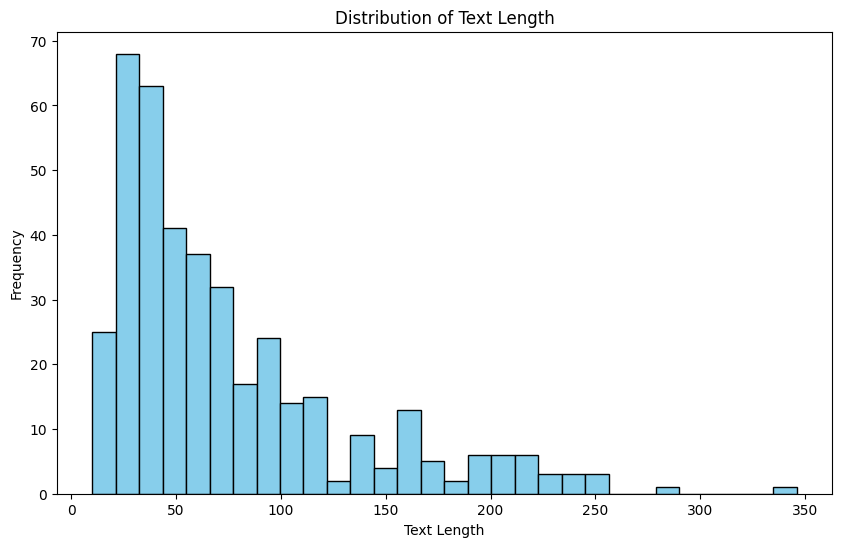

In [12]:
import matplotlib.pyplot as plt
preprocessed_df['text_length'] = preprocessed_df['text'].apply(len)
maximum_length = preprocessed_df['text_length'].max()
minimum_length = preprocessed_df['text_length'].min()
mean_length = preprocessed_df['text_length'].mean()
std_length = preprocessed_df['text_length'].std()
Q1 = preprocessed_df['text_length'].quantile(0.25)
Q2 = preprocessed_df['text_length'].quantile(0.50)
Q3 = preprocessed_df['text_length'].quantile(0.75)
print('mean : ' + str(mean_length))
print('standar deviasi : ' + str(std_length))

print('min : '+ str(minimum_length))
print('max : ' + str(maximum_length))
print('Q1 : '+ str(Q1))
print('Q2 : '+ str(Q2))
print('Q3 : '+ str(Q3))
print('IQR : '+ str(Q3-Q1))
text_length_distribution = preprocessed_df['text_length'].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(preprocessed_df['text_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [14]:
max_length = [ maximum_length, math.ceil(mean_length + std_length), math.ceil(Q3)] #max length , mean+std , q3 

In [15]:
train_padded = [1,2,3]
test_padded = [1,2,3]
for i in range (len(max_length)):
    train_padded[i] = pad_sequences(train_sequences, maxlen=max_length[i], truncating=trunc_type)
    test_padded[i] = pad_sequences(test_sequences, maxlen=max_length[i], truncating=trunc_type)

# Hyperparameter Tuning

In [28]:
def build_model(hp):
    model = tf.keras.Sequential()

    # Embedding layer
    model.add(tf.keras.layers.Embedding(input_dim=1500, output_dim=hp.Int('embedding_dim', 16, 128, 16)))
    
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        units=hp.Int('bilstm_dim', min_value=32, max_value=256, step=32),
        recurrent_activation='sigmoid'
    )))
    # Menentukan jumlah Dense Layer secara acak
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(tf.keras.layers.Dense(units=hp.Int(f'dense_units_{i}', 32, 256, 32), activation='relu'))
        # Menambahkan Dropout secara opsional
        model.add(tf.keras.layers.Dropout(rate=hp.Float(f'dropout_rate_{i}', 0.2, 0.5, 0.1)))

    # Output layer
    model.add(tf.keras.layers.Dense(4, activation='softmax'))

    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [29]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [30]:
tuner1 = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=1,
        directory='tuning_results',
        project_name='tugas_akhir_hyperparameter_tuning1'
    )

In [31]:
tuner1.search(train_padded[1], 
                np.array(train_label), 
                epochs=100, 
                batch_size=32,     # Batch size
                validation_split=0.2,
                callbacks=[early_stopping])

Trial 10 Complete [00h 00m 38s]
val_accuracy: 0.890625

Best val_accuracy So Far: 0.9375
Total elapsed time: 00h 03m 45s


In [32]:
import os
import json

# Define the parent directory containing trial subdirectories
parent_directory = "tuning_results/tugas_akhir_hyperparameter_tuning1/"

# Iterate through the trials (assumes subdirectories are named trial_00, trial_01, ..., trial_09)
for i in range(10):
    trial_dir = os.path.join(parent_directory, f"trial_{i:02d}")
    config_file = os.path.join(trial_dir, "trial.json")
    
    # Check if the file exists
    if not os.path.exists(config_file):
        print(f"File not found: {config_file}")
        continue

    # Load the trial data
    with open(config_file, "r") as f:
        trial_data = json.load(f)
    
    # Extract hyperparameter values
    hps = trial_data["hyperparameters"]["values"]

    # Extract metrics
    metrics = trial_data["metrics"]["metrics"]
    accuracy = metrics["accuracy"]["observations"][0]["value"][0]
    loss = metrics["loss"]["observations"][0]["value"][0]
    val_accuracy = metrics["val_accuracy"]["observations"][0]["value"][0]
    val_loss = metrics["val_loss"]["observations"][0]["value"][0]

    # Print trial details
    print(f"Trial ID: {trial_data['trial_id']}")
    print("Hyperparameters:")
    print(f"  Embedding Dim: {hps['embedding_dim']}")
    print(f"  LSTM Units: {hps['bilstm_dim']}")
    print(f"  Number of Dense Layers: {hps['num_dense_layers']}")
    for j in range(hps["num_dense_layers"]):
        print(f"    Dense Layer {j+1} Units: {hps[f'dense_units_{j}']}")
        print(f"    Dropout Rate for Dense Layer {j+1}: {hps[f'dropout_rate_{j}']}")

    print("\nMetrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Loss: {loss:.4f}")
    print(f"  Validation Accuracy: {val_accuracy:.4f}")
    print(f"  Validation Loss: {val_loss:.4f}")

    print("\nBest Step:", trial_data["best_step"])
    print("Trial Status:", trial_data["status"])
    print("-" * 40)


Trial ID: 00
Hyperparameters:
  Embedding Dim: 128
  LSTM Units: 224
  Number of Dense Layers: 2
    Dense Layer 1 Units: 128
    Dropout Rate for Dense Layer 1: 0.30000000000000004
    Dense Layer 2 Units: 32
    Dropout Rate for Dense Layer 2: 0.2

Metrics:
  Accuracy: 1.0000
  Loss: 0.0031
  Validation Accuracy: 0.8750
  Validation Loss: 0.9462

Best Step: 15
Trial Status: COMPLETED
----------------------------------------
Trial ID: 01
Hyperparameters:
  Embedding Dim: 128
  LSTM Units: 160
  Number of Dense Layers: 2
    Dense Layer 1 Units: 64
    Dropout Rate for Dense Layer 1: 0.30000000000000004
    Dense Layer 2 Units: 64
    Dropout Rate for Dense Layer 2: 0.2

Metrics:
  Accuracy: 1.0000
  Loss: 0.0084
  Validation Accuracy: 0.9375
  Validation Loss: 0.1863

Best Step: 14
Trial Status: COMPLETED
----------------------------------------
Trial ID: 02
Hyperparameters:
  Embedding Dim: 96
  LSTM Units: 128
  Number of Dense Layers: 2
    Dense Layer 1 Units: 32
    Dropout Rate 

In [33]:
best_hps = tuner1.get_best_hyperparameters()[0]
print(f"Embedding Dim: {best_hps.get('embedding_dim')}")
print(f"LSTM Units: {best_hps.get('bilstm_dim')}")
print(f"Number of Dense Layers: {best_hps.get('num_dense_layers')}")
for i in range(best_hps.get('num_dense_layers')):
    print(f"Dense Layer {i+1} Units: {best_hps.get(f'dense_units_{i}')}")
    print(f"Dropout Rate for Dense Layer {i+1}: {best_hps.get(f'dropout_rate_{i}')}")

Embedding Dim: 128
LSTM Units: 160
Number of Dense Layers: 2
Dense Layer 1 Units: 64
Dropout Rate for Dense Layer 1: 0.30000000000000004
Dense Layer 2 Units: 64
Dropout Rate for Dense Layer 2: 0.2


# Building Model

In [21]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
bilstm_dim = 160
dense_dim1 = 64
dropout_val1 = 0.3
dense_dim2 = 64
dropout_val2 = 0.2

In [22]:
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(bilstm_dim, recurrent_activation='sigmoid')),
    tf.keras.layers.Dense(dense_dim1, activation='relu'),
    tf.keras.layers.Dropout(dropout_val1),
    tf.keras.layers.Dense(dense_dim2, activation='relu'),
    tf.keras.layers.Dropout(dropout_val2),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
num_epochs = 100

In [25]:
history = model.fit(
    train_padded[1], 
    np.array(train_label), 
    epochs=num_epochs, 
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.2415 - loss: 1.3870 - val_accuracy: 0.1875 - val_loss: 1.3889
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.3020 - loss: 1.3803 - val_accuracy: 0.2344 - val_loss: 1.3702
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.4286 - loss: 1.3420 - val_accuracy: 0.2344 - val_loss: 1.3882
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.4988 - loss: 1.2660 - val_accuracy: 0.6406 - val_loss: 1.2124
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.5363 - loss: 1.0932 - val_accuracy: 0.5625 - val_loss: 0.9897
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.6721 - loss: 0.7659 - val_accuracy: 0.6406 - val_loss: 1.0114
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.7550 - loss: 0.5951 - val_accuracy: 0.6406 - val_loss: 0.9900
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.8449 - loss: 0.4737 - val_accuracy: 0.6875 - va

In [26]:
# Get the weights of the Embedding layer
embedding_layer = model.layers[0]  # Assuming Embedding is the first layer
embedding_weights = embedding_layer.get_weights()[0]

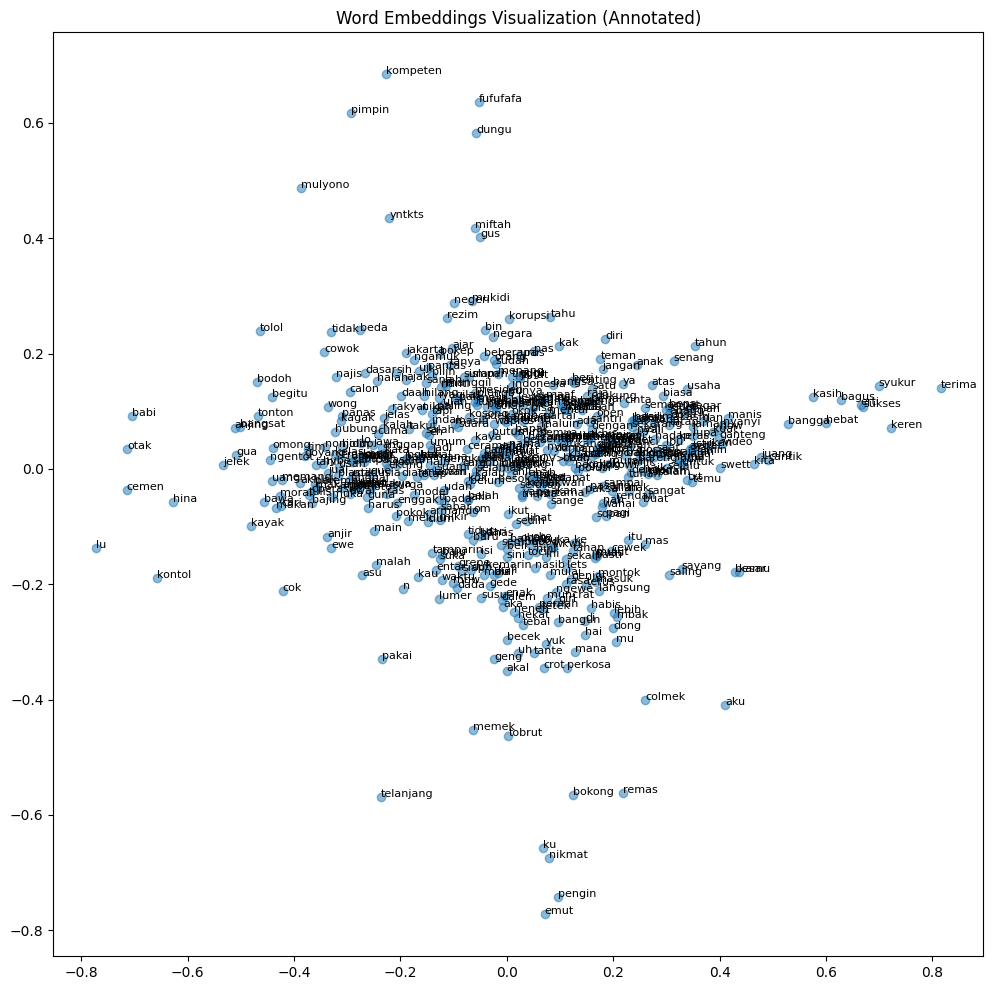

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_weights)

# Assuming you have a tokenizer with word_index mapping
word_index = tokenizer.word_index  # A dictionary mapping words to indices
index_word = {i: word for word, i in word_index.items()}  # Reverse mapping

# Plot with annotations
plt.figure(figsize=(12, 12))
for i in range(min(500, len(index_word))):  # Plot first 500 words
    word = index_word.get(i, None)
    if word:
        plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], word, fontsize=8)
plt.scatter(reduced_embeddings[:500, 0], reduced_embeddings[:500, 1], alpha=0.5)
plt.title("Word Embeddings Visualization (Annotated)")
plt.show()


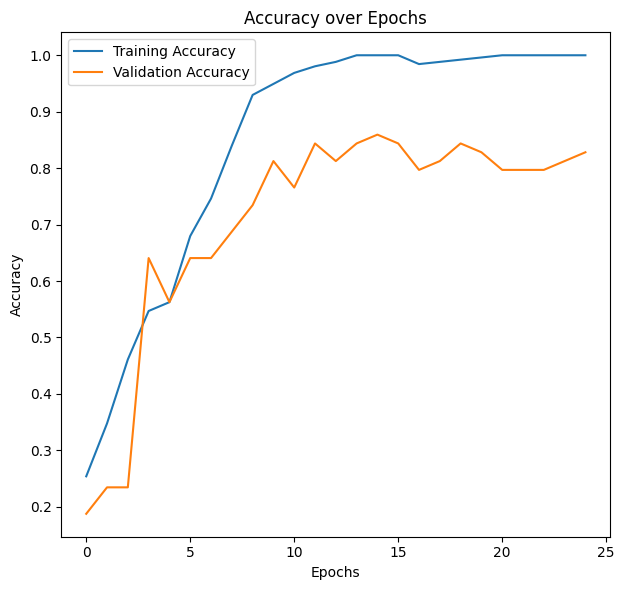

In [28]:
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

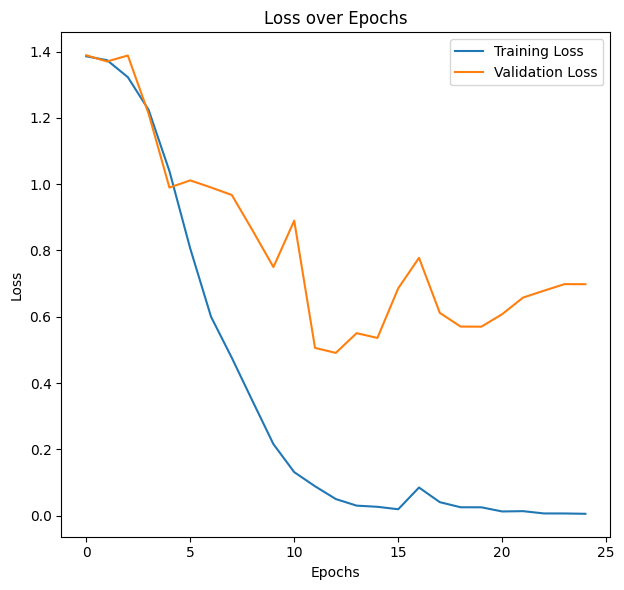

In [29]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the test set
test_predictions = model.predict(test_padded[1])

# Convert probabilities to class labels
predicted_labels = np.argmax(test_predictions, axis=1)  # Choose the class with the highest probability

# Print the classification report
print(classification_report(test_label, predicted_labels, target_names=['0', '1', '2', '3']))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
              precision    recall  f1-score   support

           0       1.00      0.74      0.85        19
           1       0.89      0.94      0.92        18
           2       0.76      0.95      0.84        20
           3       1.00      0.96      0.98        23

    accuracy                           0.90        80
   macro avg       0.91      0.90      0.90        80
weighted avg       0.92      0.90      0.90        80



1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step

/opt/homebrew/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_8. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


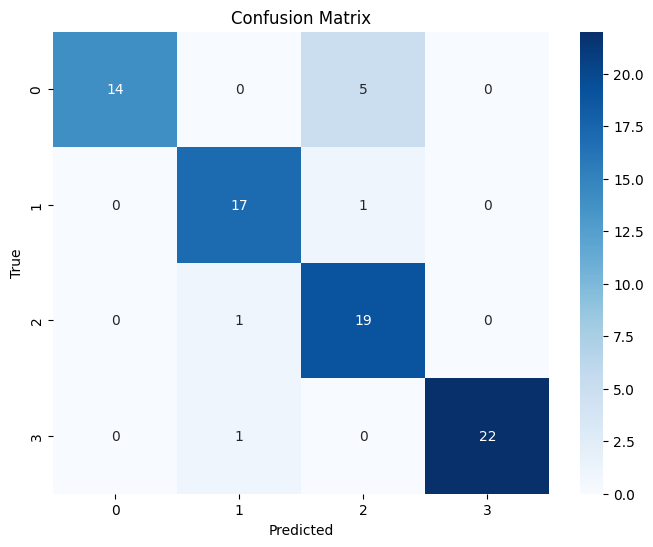

In [31]:
# Predict the test set
import seaborn as sns

test_predictions = model.predict(test_padded)
predicted_labels = np.argmax(test_predictions, axis=1)

# Generate confusion matrix
num_classes = 4  # Adjust based on the number of classes
cm = np.zeros((num_classes, num_classes), dtype=int)
for true_label, pred_label in zip(test_label, predicted_labels):
    cm[true_label][pred_label] += 1

# Create a Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
